In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
df = pd.read_csv('Delinquency_prediction_dataset.csv')

In [ ]:
df.head()

,Customer_ID,Age,Income,Credit_Score,Credit_Utilization,Missed_Payments,Delinquent_Account,Loan_Balance,Debt_to_Income_Ratio,Employment_Status,Account_Tenure,Credit_Card_Type,Location,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6
0,CUST0001,56,165580.0,398.0,0.390502,3,0,16310.0,0.317396,EMP,18,Student,Los Angeles,Late,Late,Missed,Late,Missed,Late
1,CUST0002,69,100999.0,493.0,0.312444,6,1,17401.0,0.196093,Self-employed,0,Standard,Phoenix,Missed,Missed,Late,Missed,On-time,On-time
2,CUST0003,46,188416.0,500.0,0.359930,0,0,13761.0,0.301655,Self-employed,1,Platinum,Chicago,Missed,Late,Late,On-time,Missed,Late
3,CUST0004,32,101672.0,413.0,0.371400,3,0,88778.0,0.264794,Unemployed,15,Platinum,Phoenix,Late,Missed,Late,Missed,Late,Late
4,CUST0005,60,38524.0,487.0,0.234716,2,0,13316.0,0.510583,Self-employed,11,Standard,Phoenix,Missed,On-time,Missed,Late,Late,Late


## Preprocessing

In [ ]:
df.dtypes

,0
Customer_ID,object
Age,int64
Income,float64
Credit_Score,float64
Credit_Utilization,float64
Missed_Payments,int64
Delinquent_Account,int64
Loan_Balance,float64
Debt_to_Income_Ratio,float64
Employment_Status,object


In [ ]:
df.isna().sum()

,0
Customer_ID,0
Age,0
Income,39
Credit_Score,2
Credit_Utilization,0
Missed_Payments,0
Delinquent_Account,0
Loan_Balance,29
Debt_to_Income_Ratio,0
Employment_Status,0


In [ ]:
df['Income'].fillna(df['Income'].median(), inplace=True)
df['Loan_Balance'].fillna(df['Loan_Balance'].median(), inplace=True)
df['Credit_Score'].fillna(df['Credit_Score'].mean(), inplace=True)
df.isna().sum()

/tmp/ipython-input-3-2033828909.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].median(), inplace=True)
/tmp/ipython-input-3-2033828909.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

,0
Customer_ID,0
Age,0
Income,0
Credit_Score,0
Credit_Utilization,0
Missed_Payments,0
Delinquent_Account,0
Loan_Balance,0
Debt_to_Income_Ratio,0
Employment_Status,0


In [ ]:
print( df.duplicated().sum())

0


In [ ]:
df['Employment_Status'].replace({'EMP':'Employed','employed':'Employed'},inplace=True)

/tmp/ipython-input-5-714411588.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Employment_Status'].replace({'EMP':'Employed','employed':'Employed'},inplace=True)


In [ ]:
df['Employment_Status'].value_counts()

,count
Employment_Status,
Employed,240
Unemployed,93
retired,87
Self-employed,80


## EDA

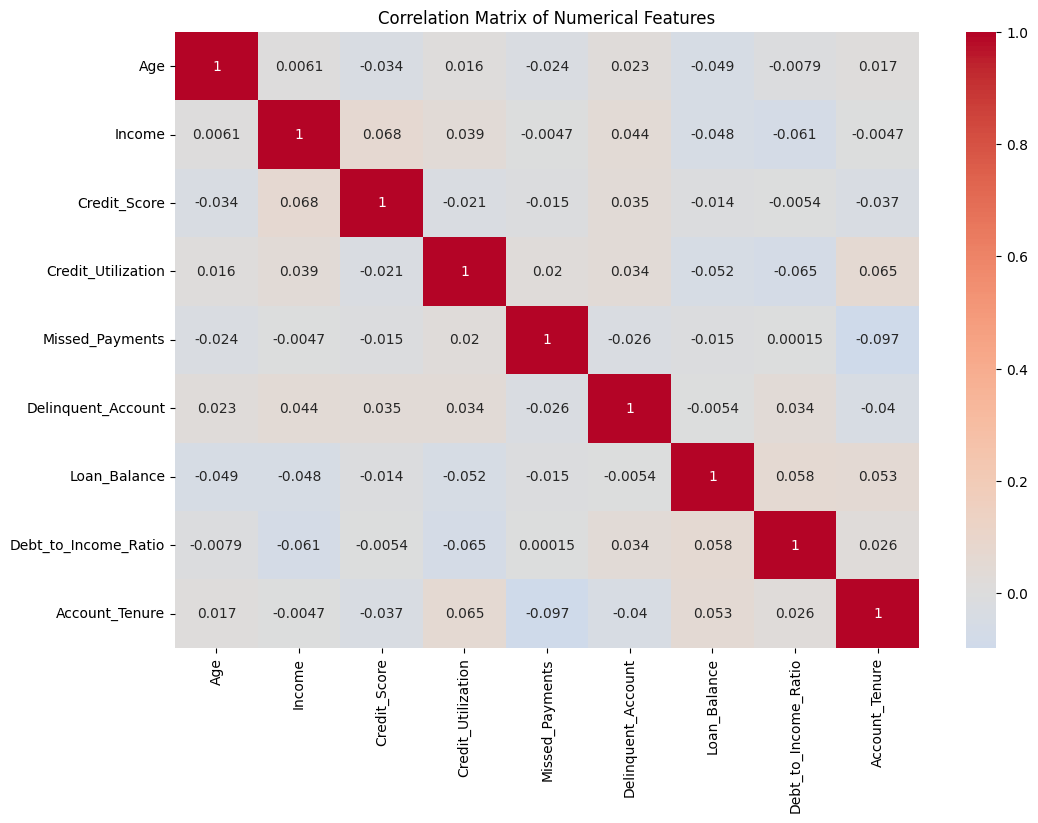

In [ ]:
# Correlation Analysis
plt.figure(figsize=(12, 8))
corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

This suggests individual features don’t strongly correlate with delinquency, but combinations (via ML models) may perform better.

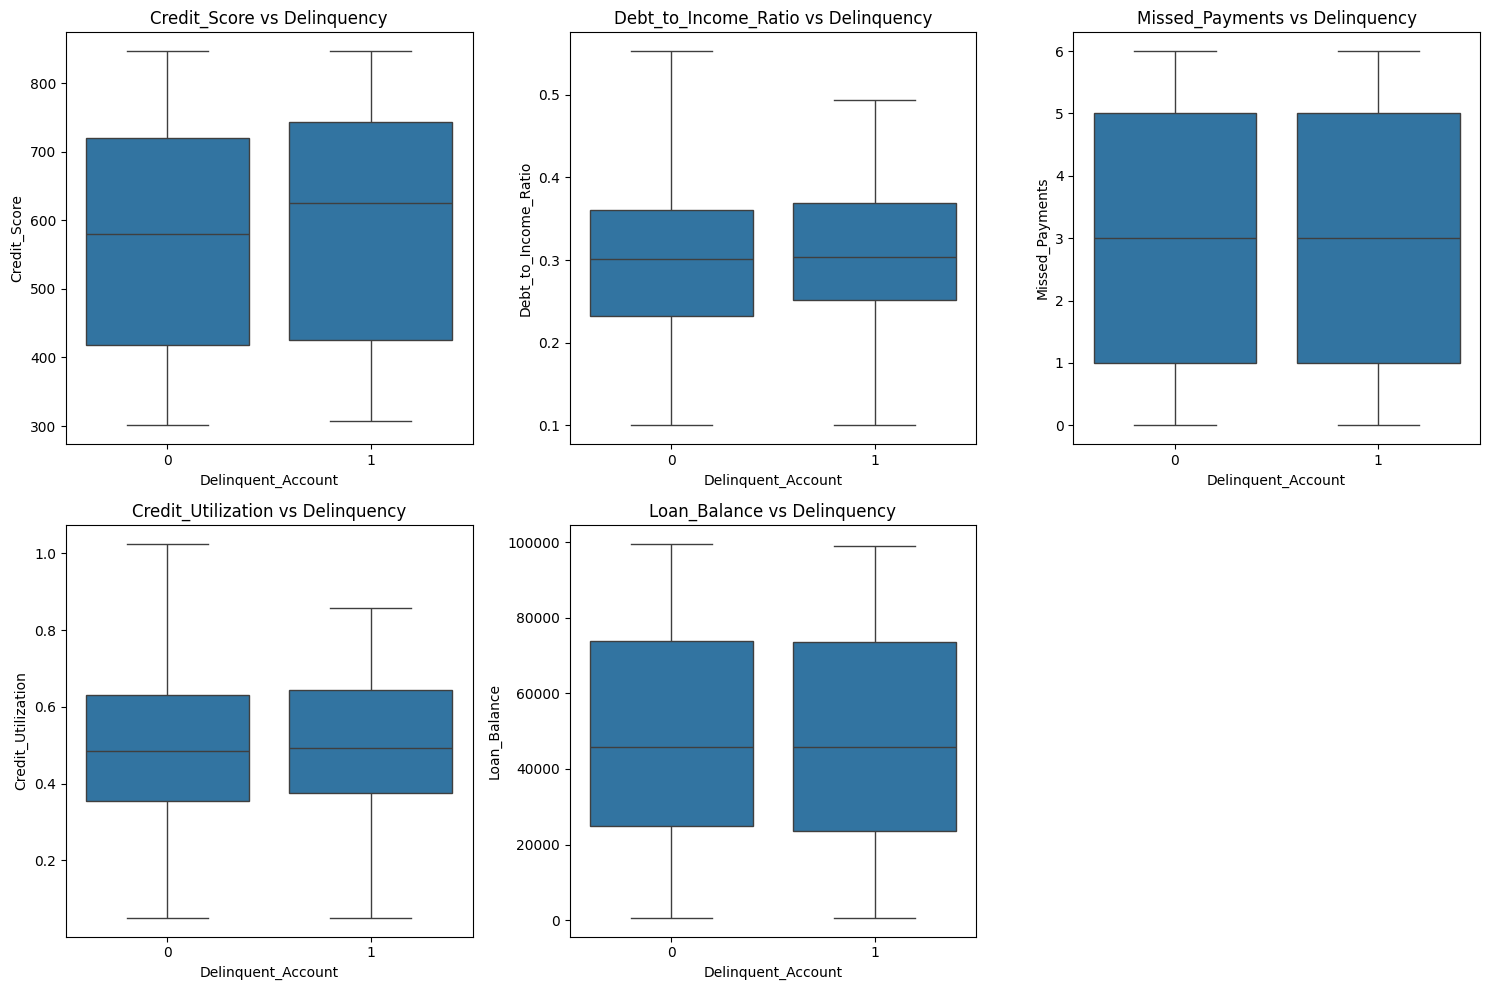

In [ ]:
# Key Feature Relationships with Delinquency
delinquency_features = ['Credit_Score', 'Debt_to_Income_Ratio', 'Missed_Payments',
                       'Credit_Utilization', 'Loan_Balance']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(delinquency_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Delinquent_Account', y=feature, data=df)
    plt.title(f'{feature} vs Delinquency')
plt.tight_layout()
plt.show()

Credit score, missed payments, and debt-to-income ratio show stronger visual separation → these are better predictors of delinquency.

<Figure size 1000x600 with 0 Axes>

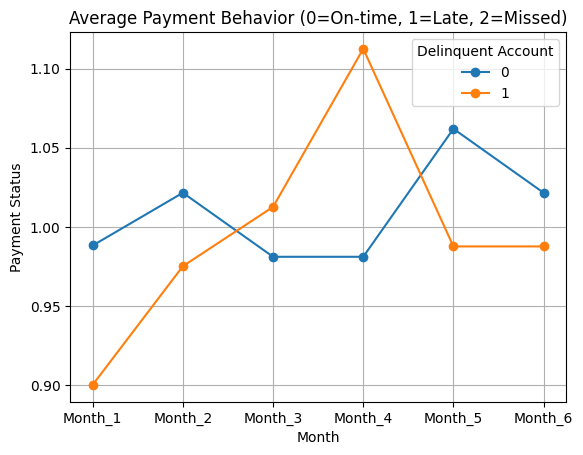

In [ ]:
# Payment History Trends
status_mapping = {
    'On-time': 0,
    'Late': 1,
    'Missed': 2
}

payment_columns = [f'Month_{i}' for i in range(1, 7)]

df[payment_columns] = df[payment_columns].apply(lambda col: col.map(status_mapping))

payment_trends = df.groupby('Delinquent_Account')[payment_columns].mean().T

plt.figure(figsize=(10, 6))
payment_trends.plot(marker='o')
plt.title('Average Payment Behavior (0=On-time, 1=Late, 2=Missed)')
plt.ylabel('Payment Status')
plt.xlabel('Month')
plt.xticks(rotation=0)
plt.legend(title='Delinquent Account')
plt.grid(True)
plt.show()

Delinquent accounts have worse and more inconsistent payment behavior across months compared to non-delinquent accounts, who are relatively more stable and timely.

0.0 → All users paid on time

1.0 → All users paid late

2.0 → All users missed payments

0.9 → Most paid on time, a few paid late

1.1 → Most paid late, a few missed

Found 0 potential anomalies (z-score > 3)


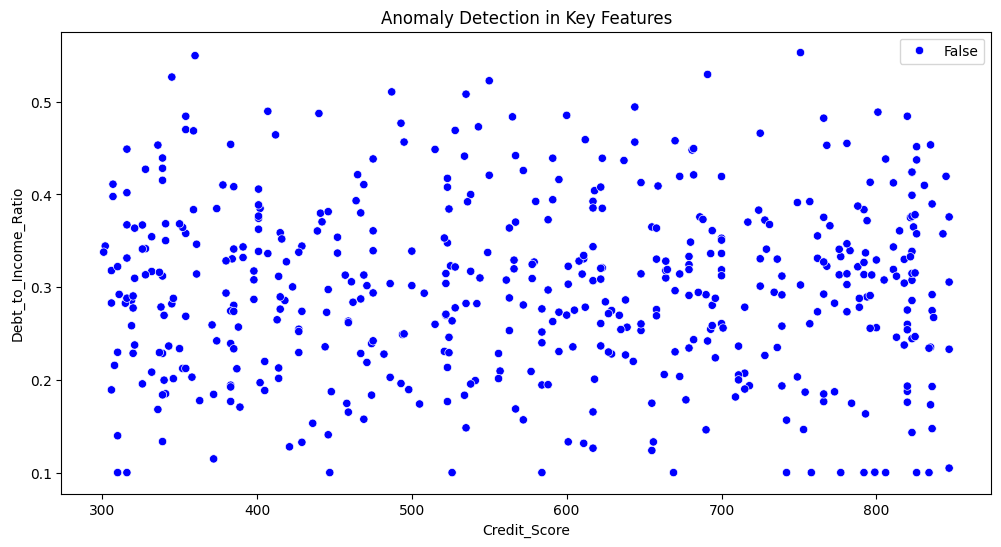

In [ ]:
# Anomaly Detection
z_scores = np.abs(stats.zscore(df.select_dtypes(include=['int64', 'float64'])))
anomalies = (z_scores > 3).any(axis=1)
print(f"Found {anomalies.sum()} potential anomalies (z-score > 3)")

# Visualize anomalies in key features
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Credit_Score', y='Debt_to_Income_Ratio',
                hue=anomalies, data=df, palette={True: 'red', False: 'blue'})
plt.title('Anomaly Detection in Key Features')
plt.show()

No anomalies found

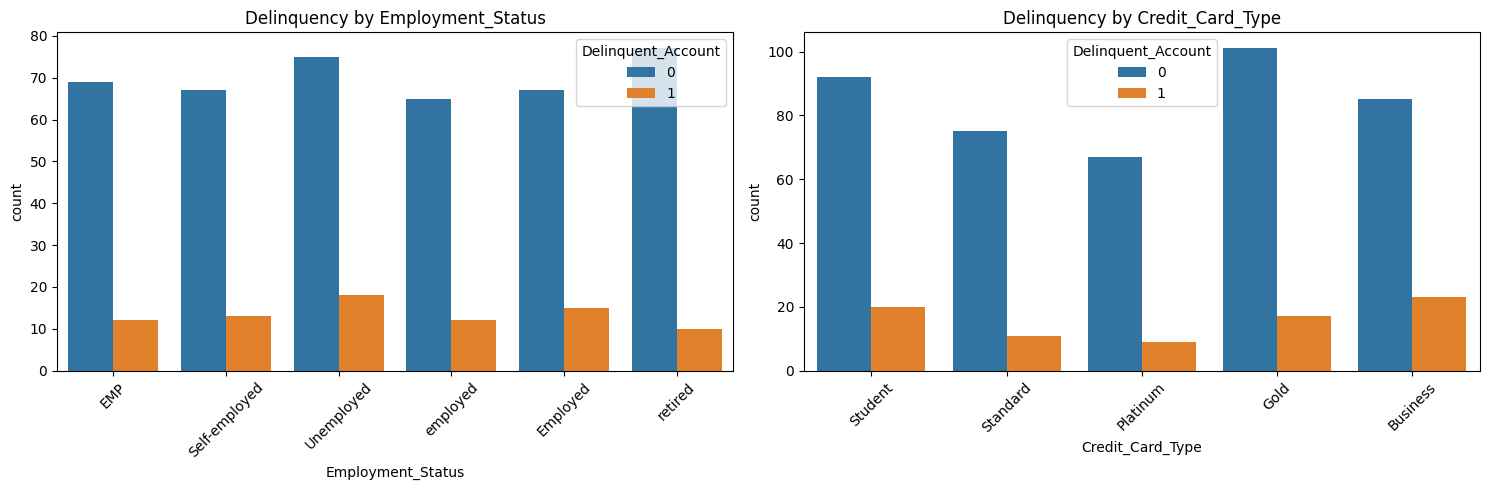

In [ ]:
# Categorical Feature Analysis
categorical_features = ['Employment_Status', 'Credit_Card_Type']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 2, i)
    sns.countplot(x=feature, hue='Delinquent_Account', data=df)
    plt.title(f'Delinquency by {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Across all employment categories, the number of non-delinquent users is significantly higher. Unemployed users have the highest number of delinquent accounts among all groups. Surprisingly, even employed/self-employed people show some delinquencies, suggesting income source alone isn’t a foolproof risk indicator.

Students and Business card holders may have higher risk, likely due to unstable income or higher spending. Premium card holders have lower delinquency, suggesting stronger credit backgrounds.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le_employment = LabelEncoder()
le_credit = LabelEncoder()

df['Employment_Status'] = le_employment.fit_transform(df['Employment_Status'])
df['Credit_Card_Type'] = le_credit.fit_transform(df['Credit_Card_Type'])

In [ ]:
df.to_csv("Delinquency_Data_Cleaned.csv")